# Label pipeline
In this notebook, we try out the entire pipeline - from D + semantic data, through building a semantic map,
to raytracing the labels back to the camera position

In [1]:
import os
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from tqdm import tqdm

from src.config import default_map_builder_cfg, default_sim_cfg
from src.features.mapping import SemanticMap3DBuilder
from src.utils import category_mapping
from src.utils.misc import get_semantic_map, semantic_map_to_categorical_map
from src.visualisation.semantic_map_visualization import visualize_map
from src.utils.category_mapping import get_instance_index_to_reseal_name_dict
from src.visualisation.instance_map_visualization import get_instance_colormap
from src.features.perception import propagate_labels
from src.utils.geometric_transformations import coordinates_to_grid_indices
from scipy.ndimage import label
from src.visualisation import instance_map_visualization



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if pathlib.PurePath(os.getcwd()).name == "notebooks":
    print(pathlib.PurePath(os.getcwd()).name)
    os.chdir("..")


notebooks


In [3]:
TRAJECTORY = "00006-HkseAnWCgqk"
DEPTH_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/D"
RGB_IMAGE_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/RGB"
POSITIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/positions.npy"
ROTATIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/rotations.npy"
SEMANTIC_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/Semantic"
trajectory_name = TRAJECTORY.split("-")[1]
SEMANTIC_INFO_FILE = f"./data/raw/train/scene_datasets/hm3d/train/{TRAJECTORY}/{trajectory_name}.semantic.txt"


In [4]:
scene_to_reseal_mapping = category_mapping.get_scene_index_to_reseal_index_map_vectorized(SEMANTIC_INFO_FILE)


Create map builder

In [5]:
sim_cfg = default_sim_cfg()
map_builder_cfg = default_map_builder_cfg()
map_builder_cfg.NUM_SEMANTIC_CLASSES = 6
map_builder_cfg.RESOLUTION = 0.05
map_builder_cfg.MAP_SIZE = [15, 1.5, 15]
map_builder = SemanticMap3DBuilder(map_builder_cfg, sim_cfg)


[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


Load poses, rgb images and depth images. Create semantic map, with RGB images as a placeholder for semantic labels

In [6]:
rotations = np.load(ROTATIONS_FILE).view(dtype=np.quaternion)
positions = np.load(POSITIONS_FILE)
scene_index_to_category_index_map = category_mapping.get_scene_index_to_reseal_index_map_vectorized(SEMANTIC_INFO_FILE)

map_builder.clear()
for i in tqdm(range(400)):
    depth_map = np.load(f"{DEPTH_MAP_DIR}/{i}.npy")
    saved_semantics = np.load(f"{SEMANTIC_MAP_DIR}/{i}.npy")
    map = get_semantic_map(saved_semantics, scene_index_to_category_index_map, map_builder_cfg.NUM_SEMANTIC_CLASSES)
    pose = (positions[i], rotations[i])
    map_builder.update_point_cloud(map, depth_map, pose, fast=True)
map_builder.concatenate_semantics()
print("Concatenating semantics done")
map_builder.update_kdtree()


100%|██████████| 400/400 [00:04<00:00, 97.70it/s] 


Concatenating semantics done


In [7]:
point_cloud = np.asarray(map_builder.point_cloud.points)
point_cloud_semantic_labels = map_builder._point_cloud_semantic_labels


Get point cloud and visualize points with semantic information

In [8]:
plot_point_cloud = True

if plot_point_cloud:
    color_converter = category_mapping.get_reseal_color_converter()

    point_cloud_categorical = np.argmax(point_cloud_semantic_labels, axis=-1) + np.sum(
        point_cloud_semantic_labels, axis=-1
    )
    # Need to initialize this as a 3 channel image so we can use numpy indexing to assign the points that have a label
    # instead of having to loop over them
    point_cloud_rgb = np.dstack([point_cloud_categorical] * 3)[0]
    point_cloud_rgb[point_cloud_categorical > 0] = color_converter(point_cloud_categorical[point_cloud_categorical > 0])

    point_cloud_o3d = o3d.utility.Vector3dVector(point_cloud[point_cloud_categorical > 0])
    pcd = o3d.geometry.PointCloud(point_cloud_o3d)
    colour = point_cloud_rgb[point_cloud_categorical > 0]
    pcd.colors = o3d.utility.Vector3dVector(colour)
    o3d.visualization.draw_geometries([pcd])


Get 3D semantic map (i.e. Voxel grid) at an index and plot it along with corresponding RGB image

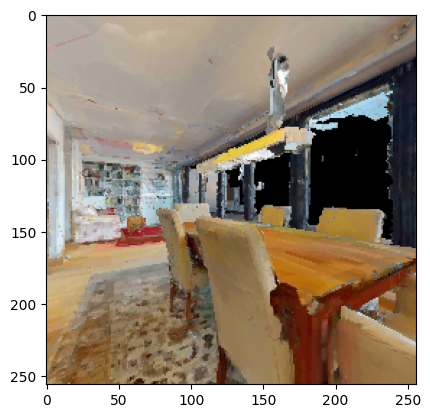

In [9]:
index = 322

rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{index}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255
plt.imshow(rgb_image)


In [10]:
map_at_index_sparse = map_builder.get_semantic_map_sparse((positions[index], 0), use_dicts=False)

from src.visualisation.semantic_map_visualization import visualize_semantic_map, visualize_categorical_label_map

plotter = visualize_semantic_map(map_at_index_sparse, opacity=0.1)

# If nothing shows here for you, try changing to jupyter_backend='pythreejs'.
plotter.show(jupyter_backend="trame")



Widget(value="<iframe src='http://localhost:42003/index.html?ui=P_0x7f174d847a90_0&reconnect=auto' style='widt…

Build categorical label map and show it

In [11]:
from src.model.perception.morphological_transformations import (
    semantic_map_to_categorical_label_map,
    fill_holes,
    remove_small_objects
)

categorical_label_map = semantic_map_to_categorical_label_map(map_at_index_sparse, no_object_threshold=0.5)


In [12]:
categorical_label_map = fill_holes(categorical_label_map, 10)
categorical_label_map = remove_small_objects(categorical_label_map, 30)


In [13]:
plotter = visualize_categorical_label_map(categorical_label_map, opacity=0.1)

plotter.show(jupyter_backend="trame")


Widget(value="<iframe src='http://localhost:42003/index.html?ui=P_0x7f1805354690_1&reconnect=auto' style='widt…

Build instance map and show it

In [14]:
instance_map_instances, num_features = label(categorical_label_map[..., 1])
instance_map = np.stack([categorical_label_map[..., 0], instance_map_instances], axis=-1)


In [15]:
plotter = instance_map_visualization.visualize_categorical_instance_map(instance_map, categorical_label_map, 0.1)
plotter.show()

Widget(value="<iframe src='http://localhost:42003/index.html?ui=P_0x7f1805102150_2&reconnect=auto' style='widt…

Raytrace in instance map and show results

In [16]:
sensor_position = positions[index]
sensor_rotation = rotations[index]

min_position, _ = map_builder.get_semantic_map_bounds(positions[index])
grid_index_of_min_position_relative_to_origin = coordinates_to_grid_indices(
    np.array(min_position), [0, 0, 0], map_builder._resolution
)
grid_index_of_origin = -grid_index_of_min_position_relative_to_origin

instance_map_2d = propagate_labels(
    sensor_rotation, sensor_position, instance_map, grid_index_of_origin, map_builder_cfg, sim_cfg.SENSOR_CFG
)

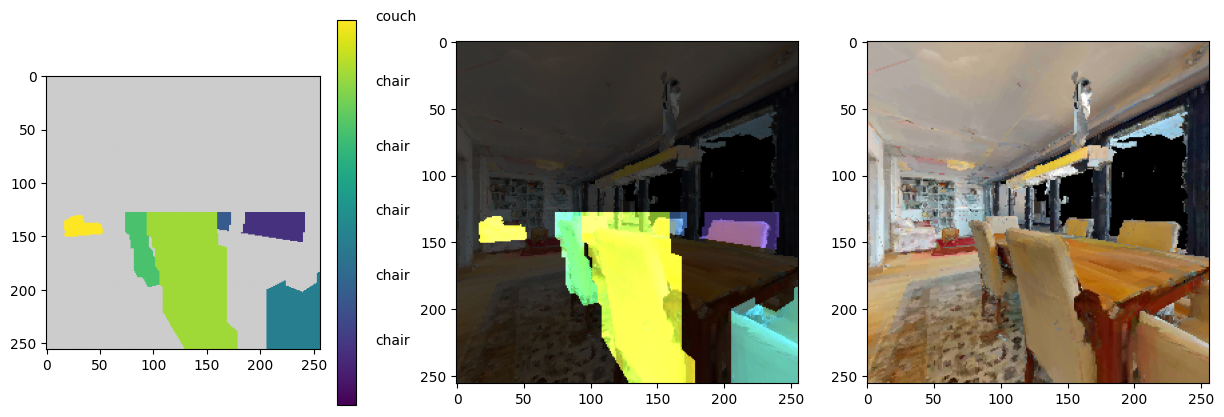

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axs
instance_map_2d_colored = get_instance_colormap(0.5)(plt.Normalize()(instance_map_2d[..., 0]))[...,:3]

# First plot
im = ax1.imshow(instance_map_2d_colored)
num_labels = np.unique(instance_map_2d[..., 0]).shape[0]
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.get_yaxis().set_ticks([])
unique_indices = np.unique(instance_map_2d[..., 0])
max_label = np.max(unique_indices)
instance_label_to_reseal_name_dict = get_instance_index_to_reseal_name_dict(instance_map, categorical_label_map)
unique_indices = [instance_label_to_reseal_name_dict[i] for i in unique_indices]

for j, label in enumerate(unique_indices[1:]):
    cbar.ax.text(2, (j+2) / (max_label), label, va='center')

# Second plot
instance_map_2d_colored[instance_map_2d_colored == 0.8] = 0
ax2.imshow(rgb_image * 0.3 + (rgb_image + 0.8) * instance_map_2d_colored)

# Third plot
ax3.imshow(rgb_image)
plt.show()
